In [1]:
import h5py
import numpy as np
import cupy as cp
import pandas as pd
from cupyx.scipy.ndimage import convolve, laplace 
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from pygments.lexers import ml
from xarray import zeros_like

from generate_psf import fit_gaussian, weighted_linear_fit
import os
import glob
import skimage
import scipy
from skimage.filters.rank import threshold
from tqdm.auto import tqdm
import cv2
from video import create_projection_image, get_lenses
import json
from daio.h5 import lazyh5


cmap = "gray"

In [2]:
pn_bg = r"~/hpc-rw/lfm/bg"
includes = ['']
excludes = []
recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_bg, '*'))), reverse=True) if os.path.exists(os.path.join(pn_bg, rec, ))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250602_1753_LB_bg_200s_2fps.npy
20250602_1749_LB_bg_100s_2fps.npy


In [3]:
bg = np.load(os.path.expanduser(os.path.join(pn_bg,"20250602_1753_LB_bg_200s_2fps.npy")))

In [4]:
# pn_rec = r"Y:/hpc/r/lfm2025/psfs"
pn_rec = r"~/hpc-r/lfm2025/psfs"
pn_out = r"~/hpc-rw/lfm/psfs"
includes = ['']
excludes = []

recs = [os.path.basename(rec) for rec in sorted(glob.glob(os.path.expanduser(os.path.join(pn_rec, '*'))), reverse=True) if os.path.exists(os.path.join(pn_rec, rec, 'psf.h5'))]
recs = [rec for rec in recs if all([s in rec for s in includes]) and not any([s in rec for s in excludes])]
print('\n'.join(recs))

20250602_1408_PSF_LB_redFB_1-90k_0.7agarose_superbright_oblong
20250602_1228_PSF_LB_redFB_1-90k_0.7agarose_3
20250530_1330_PSF_LB_redFB_1-30K_dim_isolated
20250509_1646_PSF_LB_redFB_1_30K_wo_coverslip_1
20250425_1537_PSF_LB_redFB_1-10000_2d_without_coverslip_4
20250425_1457_PSF_LB_redFB_1-10000_2d_without_coverslip_x100_1
20250425_1415_PSF_LB_redFB_1-10000_2d_without_coverslip_y100_1
20250425_1320_PSF_LB_redFB_1-10000_2d_without_coverslip_3
20250425_1242_PSF_LB_redFB_1-10000_2d_without_coverslip_2
20250425_1217_PSF_LB_redFB_1-10000_2d_without_coverslip_1
20250425_1138_PSF_LB_background
20250412_1642_PSF_LB_redFB_1-10000_withcoverslip_1
20250412_1604_PSF_LB_redFB_1-5000_withcoverslip_1
20250412_1539_PSF_LB_redFB_1-1000_withcoverslip_2
20250412_1513_PSF_LB_redFB_1-1000_withcoverslip_1


<KeysViewHDF5 ['bg', 'psf', 'z_positions']>


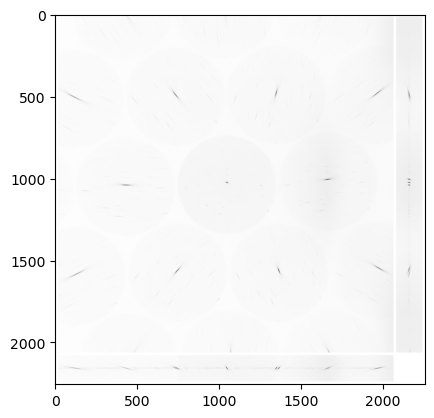

In [6]:
dataset_name = "20250425_1320_PSF_LB_redFB_1-10000_2d_without_coverslip_3"
fn = os.path.expanduser(os.path.join(pn_rec, dataset_name, 'psf.h5'))
if not os.path.exists(os.path.expanduser(os.path.join(pn_out, dataset_name))):
    os.mkdir(os.path.expanduser(os.path.join(pn_out, dataset_name)))
fn_out = os.path.expanduser(os.path.join(pn_out, dataset_name, 'psf.h5'))
with h5py.File(fn, 'r') as f:
    print(f.keys())
    psf = np.array(f['psf'])
    z_pos=  np.array(f['z_positions']) 
plt.imshow(create_projection_image(psf), cmap= "binary")
z_pos_orig=z_pos
psf_orig = psf

  0%|          | 0/160 [00:00<?, ?it/s]

79


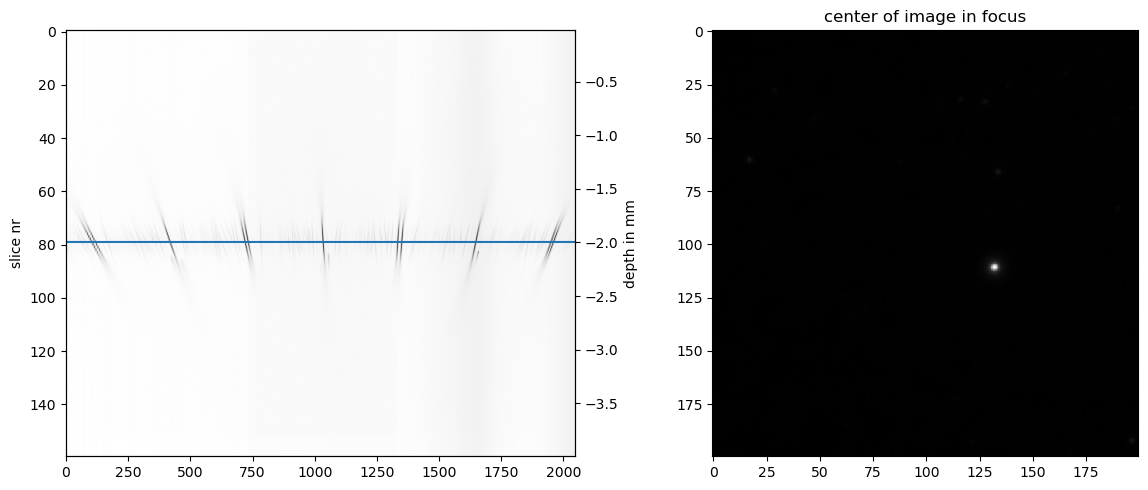

In [7]:
#find plane with best focus
scores = []
for z in tqdm(range(psf_orig.shape[0])):
    slice = cp.asarray(psf_orig[z,:,:])
    scores.append(cp.var(laplace(slice)).get())
z_focus_orig = np.argmax(scores)
# z_focus_orig = 280
print(z_focus_orig)

fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].imshow(psf_orig.max(axis=1), cmap = "binary", aspect= "auto")
ax[0].set_ylabel("slice nr")
ax[0].plot(np.ones(shape=psf.shape[1])*z_focus_orig)
right_ax = ax[0].twinx()
right_ax.set_ylim(z_pos_orig[-1], z_pos_orig[0])
right_ax.set_ylabel("depth in mm")
ax[1].imshow(psf_orig[z_focus_orig,900:1100,900:1100], cmap = "gray")
ax[1].set_title("center of image in focus")
fig.tight_layout()
fig.savefig(fn_out[:-6]+f"focus.png")

PSF zspacing: 25.00000030179567 um
(80, 2048, 2048)


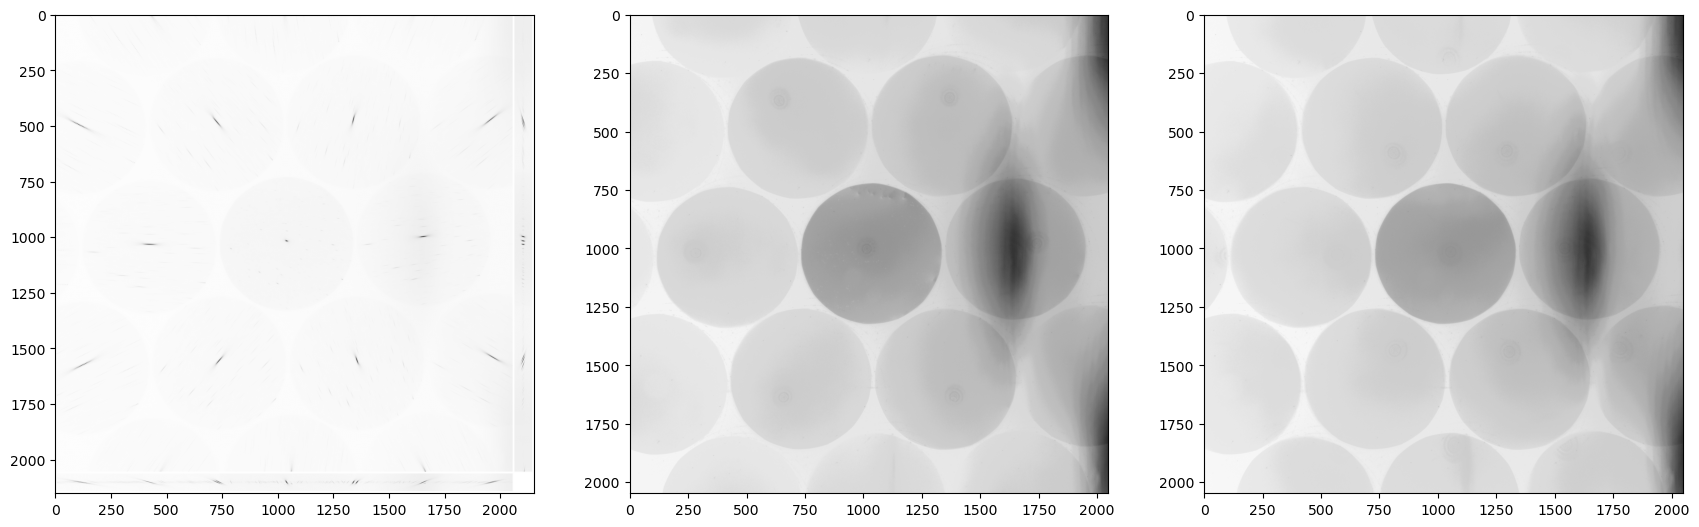

In [50]:
start =40
end=-40
downsample =1
z_focus = int((z_focus_orig-start)/downsample)

cmap = "binary"
vmax = 20
print(f"PSF zspacing: {np.abs(np.diff(z_pos_orig[start:end:downsample])).mean()*1000} um")	
psf = psf_orig[start:end:downsample,:,:]
z_pos = z_pos_orig[start:end:downsample]
print(psf.shape)
fig, ax = plt.subplots(1,3, figsize = (21,7))
ax[0].imshow(create_projection_image(psf), cmap="binary")
ax[1].imshow(psf[0], cmap = cmap, vmax =vmax)
ax[2].imshow(psf[-1], cmap = cmap, vmax =vmax)

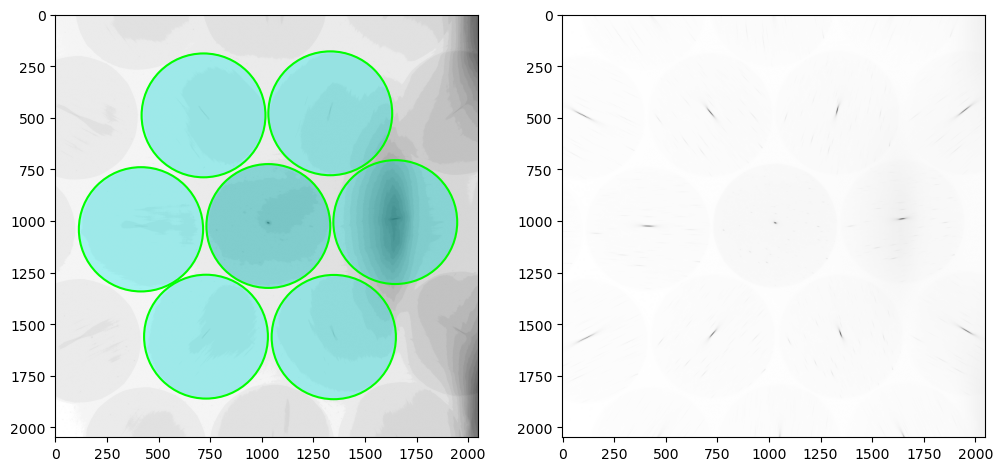

In [51]:
# detect the subimages
lenses = 7 # number of full lenses visible in the psf

meanip = cp.asarray(psf_orig).mean(axis=0).get()

cx,cy,radii, ml_masks = get_lenses(meanip)

fig, ax = plt.subplots(ncols=2, nrows=1,figsize = (12,6))
color = meanip.max()+20
for center_y, center_x, radius in zip(cy, cx, radii):
    circle = Circle((center_x, center_y), radius, edgecolor='lime', facecolor='none',  linewidth=1.5)
    ax[0].add_patch(circle)
ax[0].imshow(meanip.astype(np.uint8), cmap= "binary")


circle_mask = np.clip(ml_masks.sum(axis=0),0,1).astype(bool)
for i in range(lenses):
    mask = ml_masks[i]
    ax[0].imshow(np.ma.masked_where(~mask, mask), cmap='cool', alpha=0.3)
    
ys, xs = np.where(circle_mask)
y_min, y_max = ys.min(), ys.max()
x_min, x_max = xs.min(), xs.max()
crop = (y_min-1,y_max+1,x_min-1,x_max+1)
cropped = circle_mask[crop[0]:crop[1], crop[2]:crop[3]]

# ml_masks = ml_masks[:,crop[0]:crop[1], crop[2]:crop[3]]
ax[1].imshow(psf.max(axis=0),cmap= "binary")

  0%|          | 0/7 [00:00<?, ?it/s]

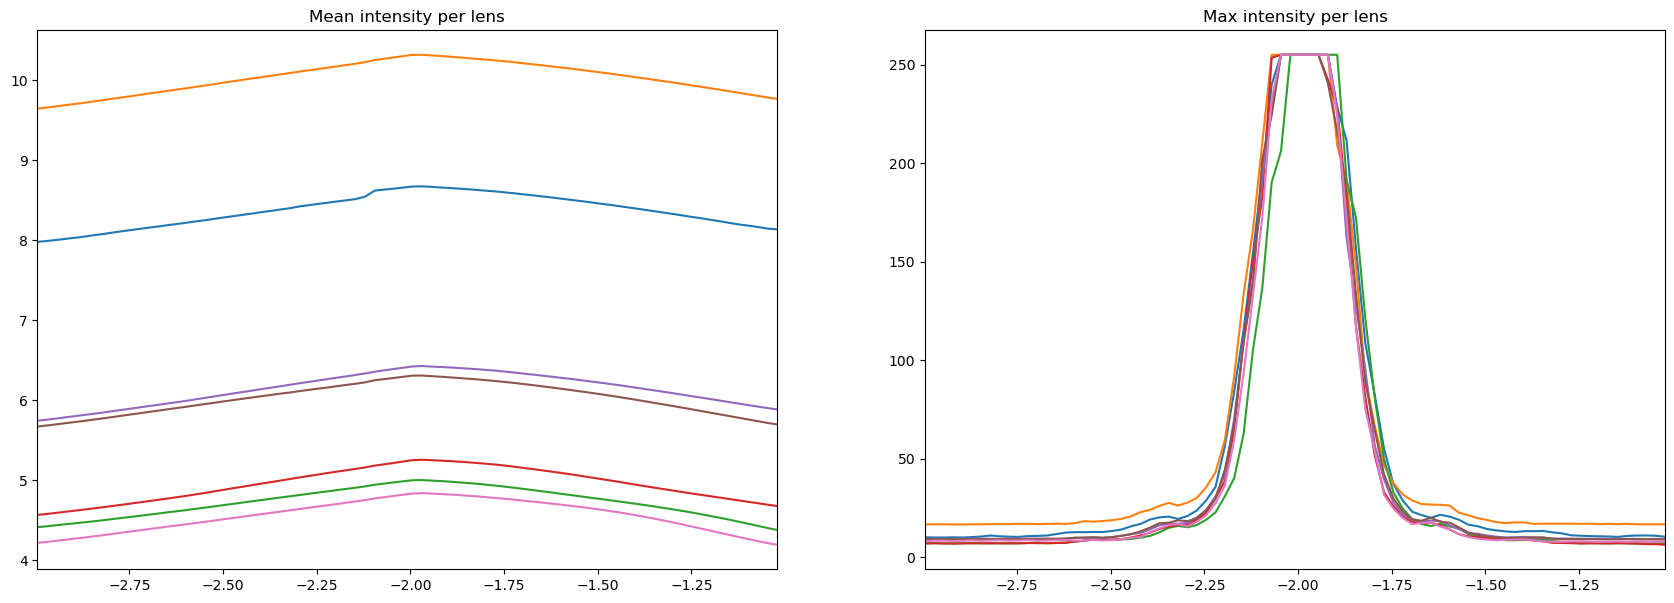

In [32]:
psf = psf_orig[start:end:downsample,crop[0]:crop[1], crop[2]:crop[3]]
# psf_ip = psf_orig[:,crop[0]:crop[1],crop[2]:crop[3]]
# z_pos_ip = z_pos_orig

psf_ip = psf
z_pos_ip = z_pos

mean_intensity = np.empty(shape=(lenses, psf_ip.shape[0]))
max_intensity = np.empty(shape=(lenses, psf_ip.shape[0]))
for i in tqdm(range(lenses)):
    mask = ml_masks[i] #cp.asarray(ml_masks[i])
    for z in range(psf_ip.shape[0]):
        slice = psf_ip[z][mask]
        mean_intensity[i,z] = slice.mean()#.get()
        max_intensity[i,z] = slice.max()#.get()
        
    # mask_3d = cp.stack([mask] * psf_cp.shape[0], axis=0)
    # mean_intensity[i,:] = psf_cp[mask_3d].mean(axis = 0).get()
    # max_intensity[i,:] = psf_cp[mask_3d].max(axis = 0).get()

x_lim = (z_pos_ip.min(),z_pos_ip.max())
# x_lim = (-1.75,-1)
fig, ax = plt.subplots(1,2,figsize=(21,7))
ax[0].plot(z_pos_ip, mean_intensity.T)
ax[0].set_title("Mean intensity per lens")
ax[0].set_xlim(x_lim[0],x_lim[1])
ax[1].plot(z_pos_ip, max_intensity.T)
# ax[1].plot(max_intensity.T)
ax[1].set_title("Max intensity per lens")
ax[1].set_xlim(x_lim[0],x_lim[1])

fig.savefig(fn_out[:-6]+f"mean_max_intensities_raw_z{abs(x_lim[0]):.4f}-{abs(x_lim[1]):.4f}.png")

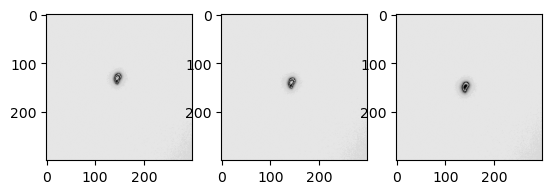

In [133]:
lens = 3
pad = 150 #how far from the center of the lens to plot
z_pad = 15# how many frames out of focus to plot, and where to stop fitting the function
vmax=20

fig, ax = plt.subplots(ncols=3, nrows=1,)

max_y,max_x = np.unravel_index(np.argmax(psf[z_focus-z_pad,:,:]*ml_masks[lens], axis=None),psf[0,:,:].shape)
im = psf[z_focus-z_pad,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min]
# im[:max_x,:max_y] = im.min()
ax[0].imshow(psf[z_focus-z_pad,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap=cmap, vmax=vmax)

ax[1].imshow(psf[z_focus,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap=cmap,vmax=vmax)
ax[2].imshow(psf[z_focus+z_pad,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap=cmap,vmax=vmax)
fig.show()

In [101]:
values_dict = {}
init_radius = 0.5
init_search_radius = 5
init_search_r_range = 3
search_radius = 5
search_r_range = 3

for lens in tqdm(range(lenses)):
    values = pd.DataFrame(index=range(psf.shape[0]), columns= ["x","y","r",], data = None)


    z = z_focus
    slice = psf[z,:,:]*ml_masks[lens]
    y_max,x_max = np.unravel_index(np.argmax(psf[z_focus,:,:]*ml_masks[lens], axis=None),psf[0,:,:].shape)
    #feel free to add better peak detection for in focus bead
    x_focus,y_focus,r_focus, corr = fit_gaussian(slice, x=x_max, y=y_max, r=init_radius, search_radius=init_search_radius, search_r_range=init_search_r_range)
    x, y, r = x_focus, y_focus, r_focus
    values.loc[z,"x"]=x
    values.loc[z,"y"]=y
    values.loc[z,"r"]=r

    while z< psf.shape[0]-1:
        z += 1
        slice = psf[z,:,:]*ml_masks[lens]
        x,y,r,corr = fit_gaussian(slice, x, y, r, search_radius=search_radius, search_r_range=search_r_range)
        values.loc[z,"x"]=x
        values.loc[z,"y"]=y
        values.loc[z,"r"]=r

    z, x, y, r = z_focus, x_focus, y_focus, r_focus
    while z > 0:
        z -= 1

        slice = psf[z,:,:]*ml_masks[lens]
        x,y,r,corr = fit_gaussian(slice, x, y, r, search_radius=search_radius,search_r_range=search_r_range)
        values.loc[z,"x"]=x
        values.loc[z,"y"]=y
        values.loc[z,"r"]=r
    
    values["x_fit"] = weighted_linear_fit(values["x"], z=z_focus, weight_sigma=20)
    values["y_fit"] = weighted_linear_fit(values["y"], z=z_focus, weight_sigma=20)

    values_dict[lens]=values

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

smoothing mask


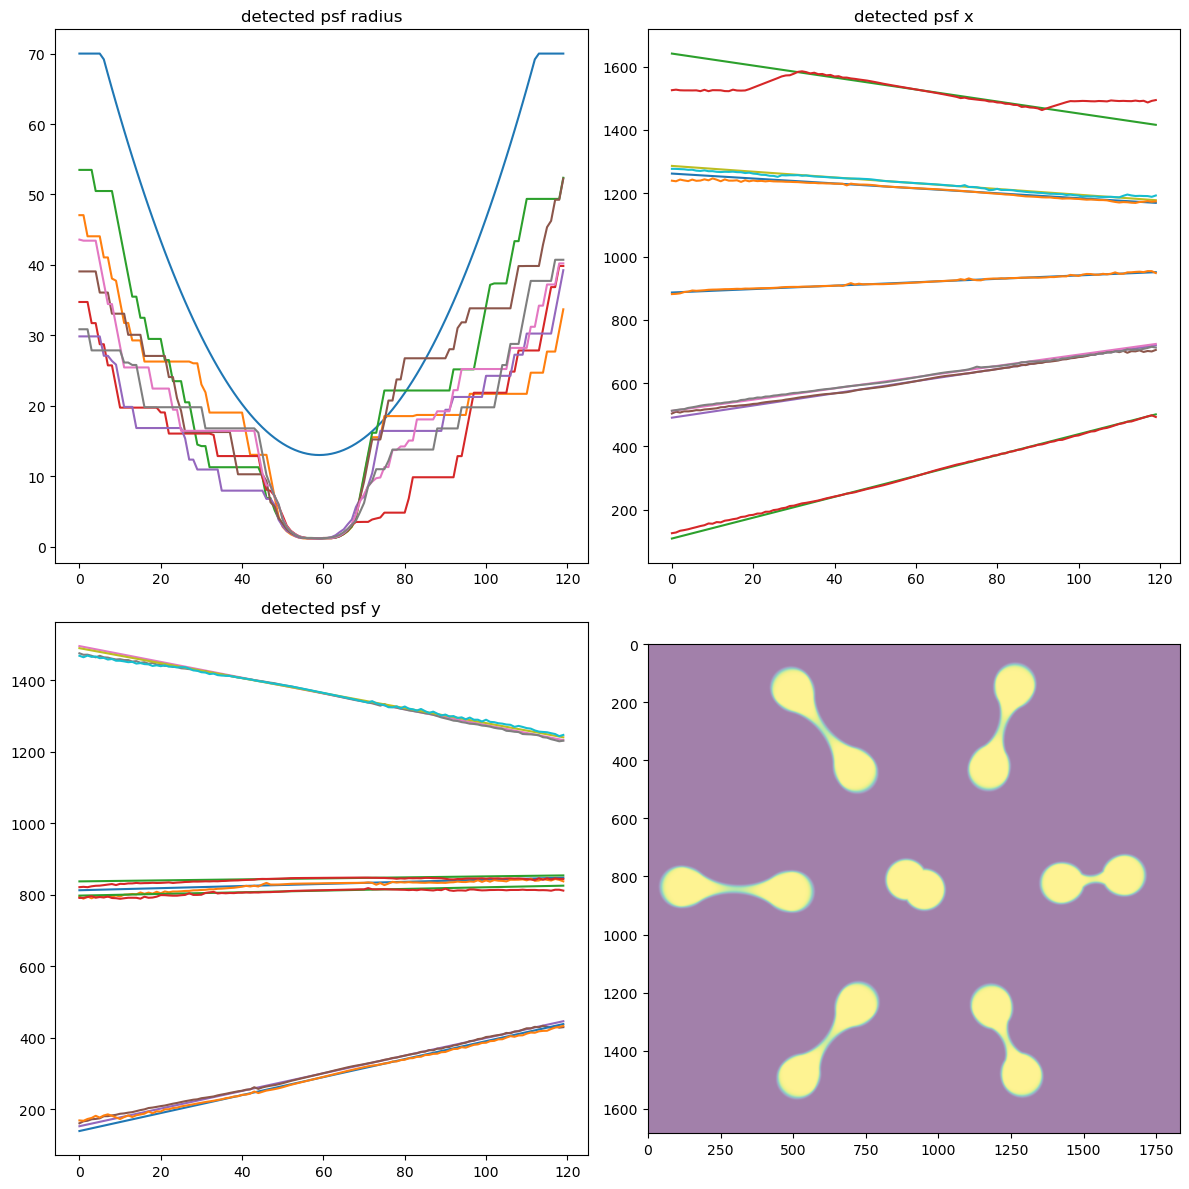

In [109]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
ax = axs.flatten()
#define filter radius

filter_radius = ((1 / 50) * (np.arange(0, psf.shape[0]) - z_focus) ** 2 + 13)
filter_radius = np.clip(filter_radius, None, 70)
ax[0].plot(filter_radius)

mask = np.zeros_like(psf).astype(bool)

for lens in tqdm(range(lenses)):
    values = values_dict[lens]    
    ax[0].plot(values["r"])
    ax[1].plot(values["x_fit"])
    ax[1].plot(values["x"])
    ax[2].plot(values["y_fit"])
    ax[2].plot(values["y"])

    temp_mask = np.zeros_like(psf).astype(bool)
    for z in range(psf.shape[0]):
        slice = temp_mask[z,:,:]
        center_x = values.loc[z,"x_fit"]
        center_y = values.loc[z,"y_fit"]
        radius = filter_radius[z]
        slice[skimage.draw.disk((center_y, center_x),radius , shape=psf.shape[1:])] = True
        temp_mask[z,:,:] = slice & ml_masks[lens]
    mask = mask | temp_mask

print("smoothing mask")
from scipy.ndimage import gaussian_filter
smooth_mask = gaussian_filter(mask.astype(float), sigma = 3)
smooth_mask = (smooth_mask - smooth_mask.min()) / (smooth_mask.max() - smooth_mask.min())

ax[0].set_title("detected psf radius") # should be somewhat parabolic, at least in center
ax[1].set_title("detected psf x") #should be linear
ax[2].set_title("detected psf y") #should be linear
ax[3].imshow(smooth_mask.max(axis=0), alpha=0.5)
fig.savefig(fn_out[:-6]+f"filter_generation.png")
fig.tight_layout()

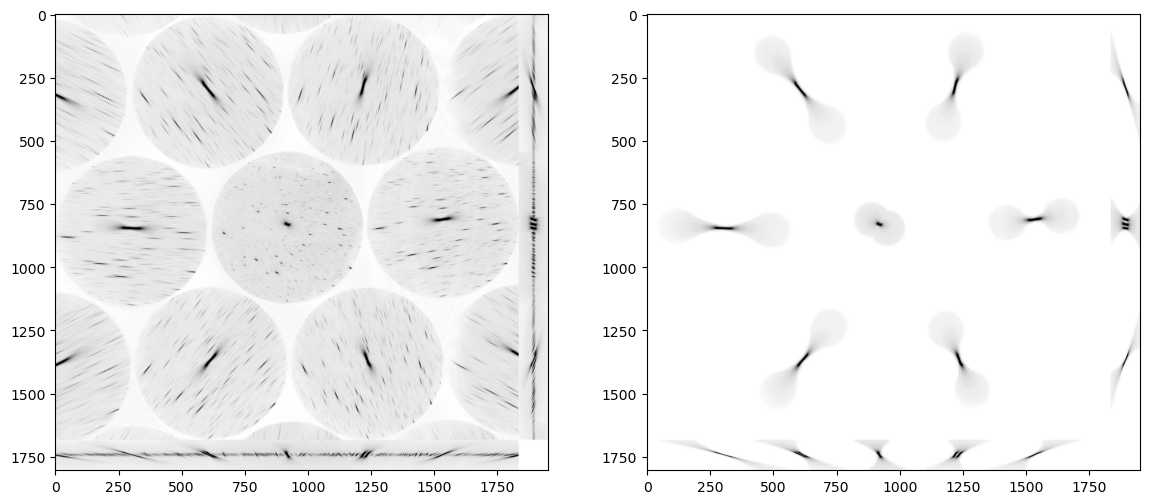

In [119]:
vmax=20
#filter
# bg_mean = bg[crop[0]:crop[1],crop[2]:crop[3]]
bg_mean = psf_orig[np.arange(-5,4),crop[0]:crop[1],crop[2]:crop[3]].mean(axis=0)
# psf_filtered = np.stack([bg_mean] * psf.shape[0], axis=0)
psf_filtered = np.ones_like(psf)
psf_filtered = (psf-bg_mean)*smooth_mask
psf_filtered = np.clip(psf_filtered,0,None)

fig, ax = plt.subplots(1,2, figsize=(14, 7))
ax[0].imshow(create_projection_image(psf-bg_mean,np.max,pad=0), cmap=cmap, vmax=vmax)
ax[1].imshow(create_projection_image(psf_filtered,np.max,pad=0), cmap=cmap,vmax=vmax)
fig.savefig(fn_out[:-6]+f"filter_comparison_mip_vmax{vmax}.png")

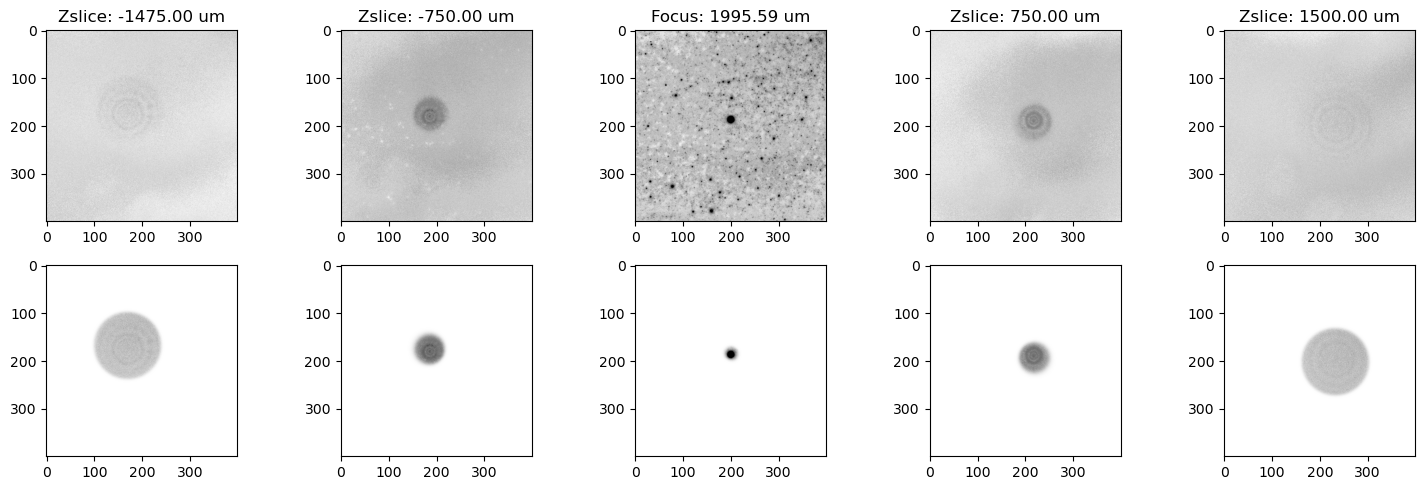

In [121]:
lens = 0
pad = 200 #how far from the center of the lens to plot
z_pad =30# how many frames out of focus to plot, and where to stop fitting the function
vmax=5
cmap = "binary"

fig, ax = plt.subplots(ncols=5, nrows=2,figsize=(15,5))

max_y,max_x = np.unravel_index(np.argmax(psf[z_focus-z_pad,:,:]*ml_masks[lens], axis=None),psf[0,:,:].shape)
im = psf_filtered[z_focus-z_pad,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min]
# im[:max_x,:max_y] = im.min()

ax[0,0].set_title(f"Zslice: {(z_pos[z_focus]-z_pos[max(z_focus-2*z_pad,0)])*1000:.2f} um")
ax[0,1].set_title(f"Zslice: {(z_pos[z_focus]-z_pos[z_focus-z_pad])*1000:.2f} um")
ax[0,2].set_title(f"Focus: {-z_pos[z_focus]*1000:.2f} um")
ax[0,3].set_title(f"Zslice: {(z_pos[z_focus]-z_pos[z_focus+z_pad])*1000:.2f} um")
ax[0,4].set_title(f"Zslice: {(z_pos[z_focus]-z_pos[min(z_focus+2*z_pad,psf.shape[0]-1)])*1000:.2f} um")

ax[0,0].imshow((psf-bg_mean)[max(z_focus-2*z_pad,0),cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap=cmap, vmax=vmax)
ax[0,1].imshow((psf-bg_mean)[z_focus-z_pad,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap=cmap, vmax=vmax)
ax[0,2].imshow((psf-bg_mean)[z_focus,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap=cmap,vmax=vmax)
ax[0,3].imshow((psf-bg_mean)[z_focus+z_pad,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap=cmap,vmax=vmax)
ax[0,4].imshow((psf-bg_mean)[min(z_focus+2*z_pad,psf.shape[0]-1),cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap=cmap, vmax=vmax)

ax[1,0].imshow(psf_filtered[max(z_focus-2*z_pad,0),cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap=cmap, vmax=vmax)
ax[1,1].imshow(psf_filtered[z_focus-z_pad,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap=cmap, vmax=vmax)
ax[1,2].imshow(psf_filtered[z_focus,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap=cmap,vmax=vmax)
ax[1,3].imshow(psf_filtered[z_focus+z_pad,cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap=cmap,vmax=vmax)
ax[1,4].imshow(psf_filtered[min(z_focus+2*z_pad,psf.shape[0]-1),cy[lens]-pad-y_min:cy[lens]+pad-y_min,cx[lens]-pad-x_min:cx[lens]+pad-x_min], cmap=cmap, vmax=vmax)
fig.tight_layout()
fig.show()
fig.savefig(fn_out[:-6]+f"filter_comparison_lens{lens}_pad{pad}_zpad{z_pad}_vmax{vmax}.png")

In [1]:
with (h5py.File(fn_out, 'w') as f):
    f["psf"] = psf_filtered
    f["circle_mask"] = circle_mask
    f["bg"] = bg_mean
    f["crop"]=crop
    f["psf_mask"] = mask
    f["ml_masks"] = ml_masks
    f["ml_cx"] = cx
    f["ml_cy"] = cy
    f["ml_radii"]=radii
    grp = f.create_group("filter_params")
    grp.attrs["z_focus"]= z_focus
    grp.attrs["lenses"] = lenses
    grp.attrs["search_radius"] = search_radius
    grp.attrs["search_r_range"] = search_r_range
    grp.attrs["init_radius"] = init_radius
    grp.attrs["init_search_radius"] = init_search_radius
    grp.attrs["init_search_r_range"] = init_search_r_range
    grp1 = f.create_group("downsample_params")
    grp1.attrs["start"] = start
    grp1.attrs["end"] = end
    grp1.attrs["downsample"] = downsample

# print("finished saving")

NameError: name 'h5py' is not defined

In [122]:
fn_out

'/home/lubo12/hpc-rw/lfm/psfs/20250425_1320_PSF_LB_redFB_1-10000_2d_without_coverslip_3/psf.h5'

In [61]:
fn_new = f'/home/lubo12/hpc-rw/PSFs/{dataset_name}psf_filtered.h5'